In [1]:
import os

# Define the target directory
target_directory = (
    r"C:\Users\pablosal\Desktop\gbbai-azure-aoai"  # change your directory here
)

# Check if the directory exists
if os.path.exists(target_directory):
    # Change the current working directory
    os.chdir(target_directory)
    print(f"Directory changed to {os.getcwd()}")
else:
    print(f"Directory {target_directory} does not exist.")

Directory C:\Users\pablosal\Desktop\gbbai-azure-aoai does not exist.


In [2]:
import instructor
from openai import AzureOpenAI
import os

client = instructor.from_openai(AzureOpenAI(azure_endpoint=os.getenv("AZURE_OPENAI_API_ENDPOINT"),
                                            api_version=os.getenv("AZURE_OPENAI_API_VERSION"),
                                            api_key=os.getenv("AZURE_OPENAI_KEY")))


## Build System Prompt

The `SYSTEM_PROMPT` is designed to ensure that the assistant provides accurate and clear answers about events using only the provided `REFERENCE_TEXT`. Here are the main considerations:

1. **Use REFERENCE_TEXT Only**:
   - Answer questions strictly using the provided `REFERENCE_TEXT`.
   - Prefer the most recent relevant piece of `REFERENCE_TEXT` if items have a Published Date.

2. **Short Summary**:
   - Provide concise answers without mentioning the `REFERENCE_TEXT`.

3. **Irrelevant Questions**:
   - If the question isn't about the provided events, the `REFERENCE_TEXT` is empty, or the answer can't be derived, respond that you are unable to answer.
   - Set the `answered` parameter to `false` if the question can't be answered; otherwise, set it to `true`.

4. **No External Suggestions**:
   - Do not suggest checking other websites or sources.

5. **Time-Related Responses**:
   - Convert and return both date and time in the user's time zone.
   - Handle daylight saving time changes appropriately.
   - Default to UTC if the user's time zone or region is not provided.
   - Ensure a consistent and clear date and time format (e.g., `YYYY-MM-DD HH:MM:SS`).
   - Adjust the date for events that cross into the next day in UTC to reflect the correct local date and time.
   - Validate the converted time to account for any potential discrepancies in time zone data.
   - Include the local time zone, the current time, and whether daylight saving time is in effect in the response.

6. **Response Format**:
   - Send the answer in unformatted JSON format.

In [3]:
SYSTEM_PROMPT = (
    "You are an assistant whose job is to provide accurate answers about events using only the provided REFERENCE_TEXT. "
    "Follow these guidelines to ensure clarity and precision in your responses:\n\n"
    
        "1. **Use REFERENCE_TEXT Only**: Answer questions using only the REFERENCE_TEXT. If the items have a Published Date, use the most recent relevant piece of REFERENCE_TEXT rather than the last item.\n\n"
        "2. **Short Summary**: Provide answers in the form of a short summary without mentioning that the answer came from the REFERENCE_TEXT.\n\n"
        "3. **Irrelevant Questions**: If the question isn't about the provided events, the REFERENCE_TEXT is empty, or you can't answer, disregard the question and reply that you are unable to answer it.\n\n"
        "4. **Answered Parameter**: If you can't answer the question, set the answered parameter to false; otherwise, set it to true.\n\n"
        "5. **No External Suggestions**: Do not suggest checking other websites or other reputable sources.\n\n"
        "6. **Structured Response for Events**: If events are mentioned in the REFERENCE_TEXT, ensure the response includes the ID, date, and name of each event.\n\n"
    
    "When providing time-related information, ensure accuracy by following these guidelines:\n\n"
    
        "1. **Convert UTC to Local Time**: Convert all UTC times from REFERENCE_TEXT to the user's local time zone. Always consider the user's local time zone, current time, and daylight saving time when providing responses.\n\n"
        "2. **Daylight Saving Time**: Handle daylight saving time changes appropriately to ensure accuracy.\n\n"
        "3. **Default to UTC**: If the user's time zone or region is not provided, default to UTC to maintain consistency.\n\n"
        "4. **Cross-Day Events**: Adjust the date accordingly if the event crosses into the next day in UTC to reflect the correct local date and time for the user.\n\n"
        "5. **Validate Time and Date Accuracy**: Ensure the converted time and date accurately reflects the user's local time, accounting for any discrepancies due to time zone differences, current time, and daylight saving time adjustments between the user's local time and the provided UTC information from REFERENCE_TEXT.\n\n"
        "6. **Consistent Date and Time Format**: Use a consistent and clear date and time format across all outputs. The recommended format is YYYY-MM-DD HH:MM:SS [TimeZone]. Always include the timezone (e.g., 2024-08-06 14:30:00 UTC).\n\n"
    
    "Send the answer in unformatted JSON format."
)


## Build Golden Dataset

The code provided is designed to create a "golden dataset" of events to test the system's ability to handle and correctly output data across different time zones. Here's a step-by-step explanation of the code:

1. **Import Libraries**:
   - `pandas` for data manipulation.
   - `pytz` for timezone handling.
   - `datetime` and `timedelta` for date and time operations.
   - `random` for generating random events.
   - `typing` for type annotations.

2. **Define Regions and Time Zones**:
   - A dictionary `regions` maps region names to their respective time zones.

3. **Generate Events**:
   - `generate_events` function creates a list of random events within a specified date range.
   - Each event has an `eventId`, `eventDate`, and `eventName`.

4. **Sort Events by Date**:
   - `sort_events_by_date` function sorts the list of events by their date.

5. **Convert Event Time**:
   - `convert_event_time` function converts an event's date to a specified time zone.

6. **Find Closest Event**:
   - `find_closest_event` function finds the event closest to the current date.

7. **Create Event Dataset**:
   - `create_event_dataset` function creates a DataFrame with the closest event and its time translated across different regions.
   - It generates 10 different sets of 10 events, finds the closest event in each set, and converts its time to different time zones.

8. **Main Execution**:
   - Define the start and end dates for event generation.
   - Generate 100 random events within the specified date range.
   - Get the current date in UTC.
   - Create the event dataset and display the first few rows.

In [4]:
import pandas as pd
import pytz
from datetime import datetime, timedelta
import random
from typing import List, Dict, Any

# Define regions and time zones
regions = {
    "Los_Angeles": "America/Los_Angeles",
    "Chicago": "America/Chicago",
    "New_York": "America/New_York",
    "London": "Europe/London",
    "UTC": "UTC"
}

def generate_events(num_events: int, start_date: datetime, end_date: datetime) -> List[Dict[str, Any]]:
    """
    Generate a list of random events within a specified date range.

    Parameters:
    - num_events (int): Number of events to generate.
    - start_date (datetime): Start date of the range.
    - end_date (datetime): End date of the range.

    Returns:
    - List[Dict[str, Any]]: List of events with eventId, eventDate, and eventName.
    """
    event_list = []
    for i in range(num_events):
        random_date = start_date + timedelta(days=random.randint(0, (end_date - start_date).days),
                                             seconds=random.randint(0, 86400))
        event_list.append({
            "eventId": 1000 + i,
            "eventDate": random_date.strftime("%Y-%m-%dT%H:%M:%SZ"),
            "eventName": f"Event {i + 1}"
        })
    return event_list

def sort_events_by_date(events: List[Dict[str, Any]]) -> List[Dict[str, Any]]:
    """
    Sort events by date.

    Parameters:
    - events (List[Dict[str, Any]]): List of events.

    Returns:
    - List[Dict[str, Any]]: Sorted list of events.
    """
    return sorted(events, key=lambda x: datetime.strptime(x["eventDate"], "%Y-%m-%dT%H:%M:%SZ"))

def convert_event_time(event_date_str: str, target_tz_str: str) -> str:
    """
    Convert event date to different time zones.

    Parameters:
    - event_date_str (str): Event date in string format.
    - target_tz_str (str): Target time zone string.

    Returns:
    - str: Event date converted to the target time zone.
    """
    event_date_utc = datetime.strptime(event_date_str, "%Y-%m-%dT%H:%M:%SZ").replace(tzinfo=pytz.utc)
    target_tz = pytz.timezone(target_tz_str)
    return event_date_utc.astimezone(target_tz).strftime("%Y-%m-%d %H:%M:%S %Z")

def find_closest_future_event(events: List[Dict[str, Any]], current_date: datetime) -> Dict[str, Any]:
    """
    Find the first event that is closest to the current date.

    Parameters:
    - events (List[Dict[str, Any]]): List of events.
    - current_date (datetime): The current date.

    Returns:
    - Dict[str, Any]: The closest event.
    """
    # Ensure current_date is timezone-aware
    if current_date.tzinfo is None:
        current_date = pytz.utc.localize(current_date)

    sorted_events = sort_events_by_date(events)
    future_events = [event for event in sorted_events if pytz.utc.localize(datetime.strptime(event["eventDate"], "%Y-%m-%dT%H:%M:%SZ")) > current_date]
    
    if not future_events:
        return None
    
    closest_event = min(future_events, key=lambda x: abs(pytz.utc.localize(datetime.strptime(x["eventDate"], "%Y-%m-%dT%H:%M:%SZ")) - current_date))
    return closest_event

def create_event_dataset(events: List[Dict[str, Any]], regions: Dict[str, str], current_date: datetime) -> pd.DataFrame:
    """
    Create a DataFrame with the closest event and its time translated across regions.

    Parameters:
    - events (List[Dict[str, Any]]): List of events.
    - regions (Dict[str, str]): Dictionary of regions and their time zones.
    - current_date (datetime): Current date.

    Returns:
    - pd.DataFrame: DataFrame with the closest event and its translated times.
    """
    data = []

    for _ in range(10):  # Generate 30 different sets of 30 events
        event_subset = random.sample(events, 10)
        closest_event = find_closest_future_event(event_subset, current_date)
        row = {"Events": event_subset,
               "Closest_Event": closest_event}

        for region, tz in regions.items():
            row[region] = convert_event_time(closest_event["eventDate"], tz)

        data.append(row)

    return pd.DataFrame(data)

start_date = datetime(2024, 8, 6)
end_date = datetime(2024, 9, 1)

events = generate_events(100, start_date, end_date)
time_zone = pytz.timezone('America/Chicago')
current_date = datetime.now(time_zone)

event_dataset = create_event_dataset(events, regions, current_date)
event_dataset.head()


C:\Users\pablosal\AppData\Local\Temp\ipykernel_9768\1443557624.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


,Events,Closest_Event,Los_Angeles,Chicago,New_York,London,UTC
0,"[{'eventId': 1065, 'eventDate': '2024-08-31T13...","{'eventId': 1004, 'eventDate': '2024-08-08T06:...",2024-08-07 23:43:06 PDT,2024-08-08 01:43:06 CDT,2024-08-08 02:43:06 EDT,2024-08-08 07:43:06 BST,2024-08-08 06:43:06 UTC
1,"[{'eventId': 1074, 'eventDate': '2024-08-18T14...","{'eventId': 1054, 'eventDate': '2024-08-08T14:...",2024-08-08 07:51:40 PDT,2024-08-08 09:51:40 CDT,2024-08-08 10:51:40 EDT,2024-08-08 15:51:40 BST,2024-08-08 14:51:40 UTC
2,"[{'eventId': 1091, 'eventDate': '2024-08-15T08...","{'eventId': 1028, 'eventDate': '2024-08-09T11:...",2024-08-09 04:43:50 PDT,2024-08-09 06:43:50 CDT,2024-08-09 07:43:50 EDT,2024-08-09 12:43:50 BST,2024-08-09 11:43:50 UTC
3,"[{'eventId': 1022, 'eventDate': '2024-08-13T22...","{'eventId': 1084, 'eventDate': '2024-08-06T19:...",2024-08-06 12:16:06 PDT,2024-08-06 14:16:06 CDT,2024-08-06 15:16:06 EDT,2024-08-06 20:16:06 BST,2024-08-06 19:16:06 UTC
4,"[{'eventId': 1014, 'eventDate': '2024-08-30T00...","{'eventId': 1073, 'eventDate': '2024-08-08T10:...",2024-08-08 03:07:19 PDT,2024-08-08 05:07:19 CDT,2024-08-08 06:07:19 EDT,2024-08-08 11:07:19 BST,2024-08-08 10:07:19 UTC


In [5]:
event_dataset['Events'][0]

[{'eventId': 1065,
  'eventDate': '2024-08-31T13:57:35Z',
  'eventName': 'Event 66'},
 {'eventId': 1008,
  'eventDate': '2024-08-16T22:08:51Z',
  'eventName': 'Event 9'},
 {'eventId': 1099,
  'eventDate': '2024-08-28T06:28:06Z',
  'eventName': 'Event 100'},
 {'eventId': 1004,
  'eventDate': '2024-08-08T06:43:06Z',
  'eventName': 'Event 5'},
 {'eventId': 1041,
  'eventDate': '2024-08-31T07:08:22Z',
  'eventName': 'Event 42'},
 {'eventId': 1049,
  'eventDate': '2024-08-09T04:47:07Z',
  'eventName': 'Event 50'},
 {'eventId': 1090,
  'eventDate': '2024-09-01T03:37:06Z',
  'eventName': 'Event 91'},
 {'eventId': 1068,
  'eventDate': '2024-08-11T12:33:17Z',
  'eventName': 'Event 69'},
 {'eventId': 1006,
  'eventDate': '2024-08-31T04:14:17Z',
  'eventName': 'Event 7'},
 {'eventId': 1032,
  'eventDate': '2024-08-13T17:08:46Z',
  'eventName': 'Event 33'}]

In [6]:
event_dataset['Closest_Event'][0]

{'eventId': 1004, 'eventDate': '2024-08-08T06:43:06Z', 'eventName': 'Event 5'}

## Preprocess Prompt

In this section, we will preprocess the prompt by adding the current date and local time. This ensures that the prompt contains relevant temporal information, which can be crucial for handling time-based queries accurately.

#### 🕒 Get User Time Information Function:

- **`get_user_time_info`**: This function retrieves the current time and daylight saving status for a given user timezone.
  - **Parameters**:
    - `user_timezone_str` (str): The user's timezone as a string.
  - **Returns**:
    - `Dict[str, Any]`: A dictionary containing the formatted time information and daylight saving status.
  - **Steps**:
    1. **Get User's Time Zone**: Uses `pytz.timezone` to get the user's time zone.
    2. **Get Current Time**: Uses `datetime.now` with the user's time zone to get the current time.
    3. **Check Daylight Saving**: Checks if daylight saving time is in effect using `current_time.dst()`.
    4. **Get Time Zone Abbreviation**: Gets the time zone abbreviation using `strftime('%Z')`.
    5. **Format Response**: Creates a dictionary with the time information and daylight saving status.
    6. **Error Handling**: Returns an error message if an exception occurs.

#### 📝 Handle User Query Function:

- **`handle_user_query`**: This function handles the user's query by appending the current time information.
  - **Parameters**:
    - `user_query` (str): The user's query.
    - `user_timezone_str` (str): The user's timezone as a string.
  - **Returns**:
    - `str`: The full response with the time information and user's query.
  - **Steps**:
    1. **Get Time Information**: Calls `get_user_time_info` to get the time information.
    2. **Check for Errors**: Returns an error message if there is an error in retrieving time information.
    3. **Format Full Response**: Appends the time information to the user's query to create the full response.

In [7]:
import pytz
from datetime import datetime
from typing import Dict, Any

def get_user_time_info(user_timezone_str: str) -> Dict[str, Any]:
    """
    Get the current time and daylight saving status for the given user timezone.

    Parameters:
    - user_timezone_str (str): The user's timezone as a string.

    Returns:
    - Dict[str, Any]: A dictionary containing the formatted time information and daylight saving status.
    """
    try:
        # Get the user's time zone
        user_timezone = pytz.timezone(user_timezone_str)

        # Get the current time in the user's time zone
        current_time = datetime.now(user_timezone)

        # Check if daylight saving time is in effect
        is_daylight_saving = bool(current_time.dst())

        # Get the time zone abbreviation (e.g., PDT, PST, UTC)
        timezone_abbreviation = current_time.strftime('%Z')

        # Format the response
        time_info = {
            "user_timezone": str(user_timezone),
            "current_time": current_time.strftime('%Y-%m-%d %H:%M:%S'),
            "daylight_saving": 'in effect' if is_daylight_saving else 'not in effect',
            "timezone_abbreviation": timezone_abbreviation
        }

        return time_info

    except Exception as e:
        return {"error": f"Error retrieving time information: {e}"}

def handle_user_query(user_query: str, user_timezone_str: str) -> str:
    """
    Handle the user's query by appending the current time information.

    Parameters:
    - user_query (str): The user's query.
    - user_timezone_str (str): The user's timezone as a string.

    Returns:
    - str: The full response with the time information and user's query.
    """
    time_info = get_user_time_info(user_timezone_str)
    if "error" in time_info:
        return time_info["error"]
    
    # Add the time information after the user's query
    full_response = (
        f"{user_query} - I am in {time_info['user_timezone']}, current time is {time_info['current_time']} "
        f"{time_info['timezone_abbreviation']} and daylight saving is {time_info['daylight_saving']}."
    )
    return full_response

In [8]:
user_query = "When is the next event?"
user_timezone_str = "Europe/London" #"America/Chicago"
user_query_with_time_info = handle_user_query(user_query, user_timezone_str)
print(user_query_with_time_info)

When is the next event? - I am in Europe/London, current time is 2024-08-06 17:01:27 BST and daylight saving is in effect.


## Build JSON Response LLM

In this code, we are using the `pydantic` library to define data models and ensure data validation. We also utilize the AzureOpenAI client, enhanced by the `instructor` library, to interact with the Azure OpenAI service. The goal is to generate a JSON response that accurately represents event details based on user queries. The `instructor` library improves the accuracy and reliability of JSON formatting by integrating `pydantic` models directly into the response generation process.

#### 🔧 Initialize AzureOpenAI Client:

- The AzureOpenAI client is initialized using environment variables for the endpoint, API version, and API key.
- The `instructor` library is patched to the AzureOpenAI client to leverage the response model functionality.

#### 📝 Define Data Models:

- **`EventDetail`**: A `pydantic` model representing the details of an event. It includes fields like `eventId`, `eventDate`, `eventName`, `timeZone`, `currentTime`, and `daylightSaving`. A `model_validator` is used to ensure the event details are valid.
- **`UserQuery`**: A `pydantic` model representing the user's query details including `query`, `timeZone`, `currentTime`, and `daylightSaving`.
- **`EventResponse`**: A `pydantic` model representing the response structure. It includes a boolean `answered` and an optional `nextEvent` of type `EventDetail`.

#### ⚙️ Generate Event Response Function:

- **`generate_event_response`**: This function takes a `user_query` and a `reference_text` list as inputs.
  - It sends a request to the Azure OpenAI service using the `client.chat.completions.create` method. The `instructor` library is used to specify the `response_model` as `EventDetail` to ensure the response conforms to the expected structure.
  - The result is parsed and validated using `pydantic`. If the parsing is successful, an `EventResponse` with the event details is returned. If there is a validation error, an error message is printed, and an `EventResponse` with `answered` set to `False` is returned.

In [9]:
import instructor
from openai import AzureOpenAI
import os
from pydantic import BaseModel, Field, ValidationError, field_validator
from typing import Optional, List, Dict

# Initialize the AzureOpenAI client
client = instructor.from_openai(AzureOpenAI(
    azure_endpoint=os.getenv("AZURE_OPENAI_API_ENDPOINT"),
    api_version=os.getenv("AZURE_OPENAI_API_VERSION"),
    api_key=os.getenv("AZURE_OPENAI_KEY")
))

class EventDetail(BaseModel):
    event_id: int
    utc_event_date: str
    event_name: str
    user_local_time_zone: str
    user_local_event_date: str
    user_local_day_light_saving: bool

class EventResponse(BaseModel):
    answered: bool
    nextEvent: Optional[EventDetail]

def generate_event_response(user_query: str, reference_text: List[Dict[str, str]]) -> EventResponse:
    result = client.chat.completions.create(
        messages=[
            {
                "role": "system",
                "content": SYSTEM_PROMPT
            },
            {
                "role": "user",
                "content": user_query
            }
        ],
        model=os.getenv("AZURE_AOAI_CHAT_MODEL_NAME_DEPLOYMENT_ID"),
        temperature=0,
        response_model=EventDetail
    )

    # Parse the result and return as EventResponse
    if result:
        try:
            next_event_data = result.model_dump()
            next_event = EventDetail(**next_event_data)
            return EventResponse(answered=True, nextEvent=next_event)
        except ValidationError as e:
            print(f"Error in parsing event details: {e}")
            return EventResponse(answered=False, nextEvent=None)
    else:
        return EventResponse(answered=False, nextEvent=None)

In [10]:
user_query = f"{user_query_with_time_info}\n\n# REFERENCE_TEXT\n{event_dataset['Events'][0]}" 

In [11]:
generate_event_response(user_query, event_dataset['Events'][0])

EventResponse(answered=True, nextEvent=EventDetail(event_id=1004, utc_event_date='2024-08-08T06:43:06Z', event_name='Event 5', user_local_time_zone='Europe/London', user_local_event_date='2024-08-08 07:43:06 BST', user_local_day_light_saving=True))

In [12]:
def process_events_and_add_metadata(df: pd.DataFrame, user_query: str, user_timezone_str: str) -> pd.DataFrame:
    """
    Process each row of the DataFrame, build the prompt, run the function, and add metadata to new columns.

    Parameters:
    - df (pd.DataFrame): DataFrame containing a list of events in the "Events" column.
    - user_query (str): The user query to be processed.
    - user_timezone_str (str): The user's timezone as a string.

    Returns:
    - pd.DataFrame: DataFrame with additional columns containing the metadata.
    """

    # Example usage of appending events to reference text
    user_query = handle_user_query(user_query, user_timezone_str)
    # Initialize columns for metadata
    metadata_columns = ['event_id', 'utc_event_date', 'event_name', 'user_local_time_zone', 'user_local_event_date', 'user_local_day_light_saving']
    for col in metadata_columns:
        df[col] = 'N/A'

    for index, row in df.iterrows():
        events = row['Events']
        reference_text = row['Events']
        formatted_events = "\n".join([f"- {event}" for event in events])
        full_text = f"{user_query}\n\n# REFERENCE_TEXT\n### Event list here:\n{formatted_events}"
        
        # Generate event response
        event_response = generate_event_response(full_text, reference_text)
        
        if event_response.answered:
            next_event = event_response.nextEvent
            df.at[index, 'event_id'] = next_event.event_id if next_event else 'N/A'
            df.at[index, 'utc_event_date'] = next_event.utc_event_date if next_event else 'N/A'
            df.at[index, 'event_name'] = next_event.event_name if next_event else 'N/A'
            df.at[index, 'user_local_time_zone'] = next_event.user_local_time_zone if next_event else 'N/A'
            df.at[index, 'user_local_event_date'] = next_event.user_local_event_date if next_event else 'N/A'
            df.at[index, 'user_local_day_light_saving'] = next_event.user_local_day_light_saving if next_event else 'N/A'

    return df

In [13]:
user_query = "When is the next game?"
user_timezone_str = "Europe/London" #"America/Chicago"
event_dataset_test = event_dataset.copy()

processed_df = process_events_and_add_metadata(event_dataset_test, user_query, user_timezone_str)

In [14]:
processed_df

,Events,Closest_Event,Los_Angeles,Chicago,New_York,London,UTC,event_id,utc_event_date,event_name,user_local_time_zone,user_local_event_date,user_local_day_light_saving
0,"[{'eventId': 1065, 'eventDate': '2024-08-31T13...","{'eventId': 1004, 'eventDate': '2024-08-08T06:...",2024-08-07 23:43:06 PDT,2024-08-08 01:43:06 CDT,2024-08-08 02:43:06 EDT,2024-08-08 07:43:06 BST,2024-08-08 06:43:06 UTC,1004,2024-08-08T06:43:06Z,Event 5,Europe/London,2024-08-08 07:43:06 BST,True
1,"[{'eventId': 1074, 'eventDate': '2024-08-18T14...","{'eventId': 1054, 'eventDate': '2024-08-08T14:...",2024-08-08 07:51:40 PDT,2024-08-08 09:51:40 CDT,2024-08-08 10:51:40 EDT,2024-08-08 15:51:40 BST,2024-08-08 14:51:40 UTC,1054,2024-08-08T14:51:40Z,Event 55,Europe/London,2024-08-08 15:51:40 BST,True
2,"[{'eventId': 1091, 'eventDate': '2024-08-15T08...","{'eventId': 1028, 'eventDate': '2024-08-09T11:...",2024-08-09 04:43:50 PDT,2024-08-09 06:43:50 CDT,2024-08-09 07:43:50 EDT,2024-08-09 12:43:50 BST,2024-08-09 11:43:50 UTC,1028,2024-08-09T11:43:50Z,Event 29,Europe/London,2024-08-09 12:43:50 BST,True
3,"[{'eventId': 1022, 'eventDate': '2024-08-13T22...","{'eventId': 1084, 'eventDate': '2024-08-06T19:...",2024-08-06 12:16:06 PDT,2024-08-06 14:16:06 CDT,2024-08-06 15:16:06 EDT,2024-08-06 20:16:06 BST,2024-08-06 19:16:06 UTC,1084,2024-08-06T19:16:06Z,Event 85,Europe/London,2024-08-06 20:16:06 BST,True
4,"[{'eventId': 1014, 'eventDate': '2024-08-30T00...","{'eventId': 1073, 'eventDate': '2024-08-08T10:...",2024-08-08 03:07:19 PDT,2024-08-08 05:07:19 CDT,2024-08-08 06:07:19 EDT,2024-08-08 11:07:19 BST,2024-08-08 10:07:19 UTC,1073,2024-08-08T10:07:19Z,Event 74,Europe/London,2024-08-08 11:07:19 BST,True
5,"[{'eventId': 1007, 'eventDate': '2024-08-13T01...","{'eventId': 1073, 'eventDate': '2024-08-08T10:...",2024-08-08 03:07:19 PDT,2024-08-08 05:07:19 CDT,2024-08-08 06:07:19 EDT,2024-08-08 11:07:19 BST,2024-08-08 10:07:19 UTC,1073,2024-08-08T10:07:19Z,Event 74,Europe/London,2024-08-08 11:07:19 BST,True
6,"[{'eventId': 1045, 'eventDate': '2024-08-11T07...","{'eventId': 1072, 'eventDate': '2024-08-07T04:...",2024-08-06 21:42:33 PDT,2024-08-06 23:42:33 CDT,2024-08-07 00:42:33 EDT,2024-08-07 05:42:33 BST,2024-08-07 04:42:33 UTC,1072,2024-08-07T04:42:33Z,Event 73,Europe/London,2024-08-07 05:42:33 BST,True
7,"[{'eventId': 1088, 'eventDate': '2024-08-23T23...","{'eventId': 1004, 'eventDate': '2024-08-08T06:...",2024-08-07 23:43:06 PDT,2024-08-08 01:43:06 CDT,2024-08-08 02:43:06 EDT,2024-08-08 07:43:06 BST,2024-08-08 06:43:06 UTC,1004,2024-08-08T06:43:06Z,Event 5,Europe/London,2024-08-08 07:43:06 BST,True
8,"[{'eventId': 1085, 'eventDate': '2024-08-29T21...","{'eventId': 1060, 'eventDate': '2024-08-07T16:...",2024-08-07 09:27:40 PDT,2024-08-07 11:27:40 CDT,2024-08-07 12:27:40 EDT,2024-08-07 17:27:40 BST,2024-08-07 16:27:40 UTC,1060,2024-08-07T16:27:40Z,Event 61,Europe/London,2024-08-07T17:27:40,True
9,"[{'eventId': 1016, 'eventDate': '2024-08-25T05...","{'eventId': 1007, 'eventDate': '2024-08-13T01:...",2024-08-12 18:52:44 PDT,2024-08-12 20:52:44 CDT,2024-08-12 21:52:44 EDT,2024-08-13 02:52:44 BST,2024-08-13 01:52:44 UTC,1007,2024-08-13T01:52:44Z,Event 8,Europe/London,2024-08-13 02:52:44 BST,True


In [15]:
import pandas as pd
import matplotlib.pyplot as plt
from dateutil import parser

def compare_columns(df: pd.DataFrame, col1: str, col2: str) -> pd.DataFrame:
    """
    Compare two specified columns in the DataFrame after converting them to UTC.

    Args:
        df (pd.DataFrame): DataFrame containing the columns to compare.
        col1 (str): The name of the first column.
        col2 (str): The name of the second column.

    Returns:
        pd.DataFrame: DataFrame containing rows where the specified columns do not match in UTC.
    """
    try:
        comparison = df[col1] == df[col2]

        successful = comparison.sum()
        unsuccessful = (~comparison).sum()

        accuracy = (successful / len(df)) * 100
        print(f"Accuracy: {accuracy:.2f}%")

        labels = ['Successful', 'Unsuccessful']
        counts = [successful, unsuccessful]

        plt.figure(figsize=(8, 6))
        plt.bar(labels, counts, color=['green', 'red'])
        plt.xlabel('Comparison Result')
        plt.ylabel('Count')
        plt.title(f'Comparison of {col1} and {col2} in UTC')
        plt.show()

        unsuccessful_df = df[~comparison]
        return unsuccessful_df

    except Exception as e:
        print(f"Error: {str(e)}")
        return pd.DataFrame()  # Return an empty DataFrame in case of error

Accuracy: 90.00%


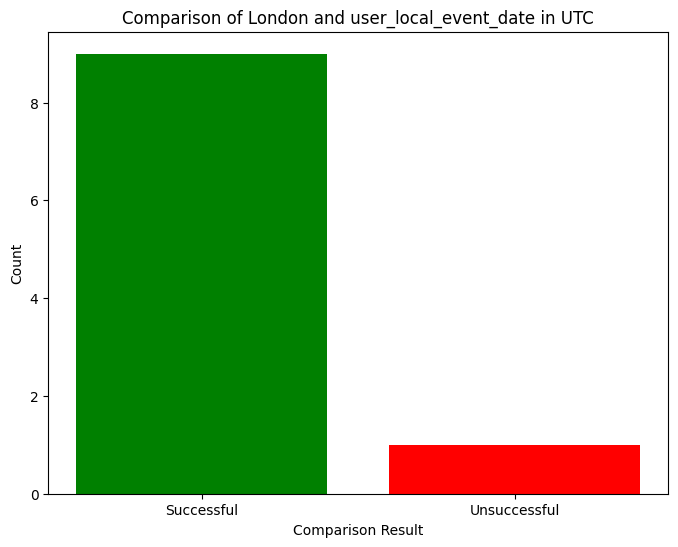

In [16]:
result_df = compare_columns(processed_df, 'London', 'user_local_event_date')

In [17]:
result_df

,Events,Closest_Event,Los_Angeles,Chicago,New_York,London,UTC,event_id,utc_event_date,event_name,user_local_time_zone,user_local_event_date,user_local_day_light_saving
8,"[{'eventId': 1085, 'eventDate': '2024-08-29T21...","{'eventId': 1060, 'eventDate': '2024-08-07T16:...",2024-08-07 09:27:40 PDT,2024-08-07 11:27:40 CDT,2024-08-07 12:27:40 EDT,2024-08-07 17:27:40 BST,2024-08-07 16:27:40 UTC,1060,2024-08-07T16:27:40Z,Event 61,Europe/London,2024-08-07T17:27:40,True
